# Convolutional Neural Networks for Image Colouration and Segmentation



In this project we  focus on the applications of convolutional neural networks in various image processing tasks. First, we train a convolutional neural network for a task known as image colourization. That is, given a greyscale image, we will predict the colour at each pixel. This a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple, equally valid colourings. 

Second, we perform fine-tuning on a pre-trained semantic segmentation model. Semantic segmentation attempts to cluster the areas of an image which belongs to the same object (label), and treats each pixel as a classification problem. We will fine-tune a pre-trained convolutional neural network (CNN) featuring dilated convolution to segment flowers from the [Oxford17 flower dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/).

This project can also be found on my [Github](https://github.com/rizkmena/Convolutional-Neural-Networks-for-Image-Colouration-and-Segmentation).

## Setup: Download CIFAR and Colour dictionary
We use the [CIFAR-10 data set](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz), which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. To make the problem easier, we will only use the Dog category from this data set. Now let’s learn to colour some dogs!

The data loading script is included below. It can take up to a couple of minutes to download everything the first time.


In [ ]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/temp/
%cd /content/csc413/temp

######################################################################
# Helper functions for loading data
######################################################################
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
from six.moves.urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys
from PIL import Image


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print('File path: %s' % fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

## Downloading Files

This may take 1 or 2 mins for the first time.

In [ ]:
# Download cluster centers for k-means over colours
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz', 
                         untar=True)
# Download CIFAR dataset
m = load_cifar10()

File path: data/colours.tar.gz
('Downloading data from', 'http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz')
Extracting file.
File path: data/cifar-10-batches-py.tar.gz
('Downloading data from', 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
Extracting file.


# Part 2: Colourization as Classification
In this section, we  perform image colourization using a convolutional neural network. Given a
grayscale image, we wish to predict the colour of each pixel.
<br>
We select a subset of 24 colours and frame colourization as a pixel-wise classification problem, where we label each pixel with one of 24 colours. The 24 colours are selected using [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) over colours, and selecting cluster centers. 
<br>
For simplicity, we will measure distance in RGB space. This is not ideal but reduces the software dependencies for this project.

## 1.1. Helper Code
Before implementing the CNN model, we first get some helper code out of the way. This section contains helper code for manipulating the data, working with PyTorch, visualizing our results, and implementing the training loop.

In [ ]:

from __future__ import print_function
import argparse
import math
import numpy as np
import numpy.random as npr
import scipy.misc
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt 


DOG_CLASS = 5

### 1.1.1. Data Manipulation

In [ ]:
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _get_rgb_cat

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result

def _get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `xs`. This function is a little memory
    intensive, and so the size of `xs` should not be too large.

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours,1,3,1,1])
    dists = np.linalg.norm(xs-cs, axis=2) # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat

def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]

def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the dog category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == DOG_CLASS)[0], :, :, :]
    npr.shuffle(xs)
    
    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
      downsize_module = nn.Sequential(nn.AvgPool2d(2),
                               nn.AvgPool2d(2), 
                               nn.Upsample(scale_factor=2), 
                               nn.Upsample(scale_factor=2))
      xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
      xs_downsized = xs_downsized.data.numpy()
      return (xs, xs_downsized)
    else:
      return (xs, grey)


def get_batch(x, y, batch_size):
    '''
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    '''
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i:i+batch_size, :,:,:]
        batch_y = y[i:i+batch_size, :,:,:]
        yield (batch_x, batch_y)

### 1.1.2. Torch Helper

In [ ]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels 
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    """
    Helper function to compute the loss. Since this is a pixelwise
    prediction task we need to reshape the output and ground truth
    tensors into a 2D tensor before passing it in to the loss criteron.

    Args:
      criterion: pytorch loss criterion
      outputs (pytorch tensor): predicted labels from the model
      labels (pytorch tensor): ground truth labels
      batch_size (int): batch size used for training
      num_colours (int): number of colour categories
    Returns:
      pytorch tensor for loss
    """

    loss_out = outputs.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32, num_colours])
    loss_lab = labels.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32])
    return criterion(loss_out, loss_lab)

def run_validation_step(cnn, criterion, test_grey, test_rgb_cat, batch_size,
                        colours, plotpath=None, visualize=True, downsize_input=False):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_grey,
                                           test_rgb_cat,
                                           batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if plotpath: # only plot if a path is provided
        plot(xs, ys, predicted.cpu().numpy(), colours, 
             plotpath, visualize=visualize, compare_bilinear=downsize_input)

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

#### 1.1.3. Visualization

In [ ]:
def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
      visualize: display the figures inline or save the figures in path
    """
    grey = np.transpose(input[:10,:,:,:], [0,2,3,1])
    gtcolor = get_cat_rgb(gtlabel[:10,0,:,:], colours)
    predcolor = get_cat_rgb(output[:10,0,:,:], colours)

    img_stack = [
      np.hstack(np.tile(grey, [1,1,1,3])),
      np.hstack(gtcolor),
      np.hstack(predcolor)]
    
    if compare_bilinear:
      downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                 nn.AvgPool2d(2), 
                                 nn.Upsample(scale_factor=2, mode='bilinear'), 
                                 nn.Upsample(scale_factor=2, mode='bilinear'))
      gt_input = np.transpose(gtcolor, [0, 3, 1, 2,])
      color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
      color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
      img_stack = [
        np.hstack(np.transpose(input[:10,:,:,:], [0,2,3,1])),
        np.hstack(gtcolor),
        np.hstack(predcolor),
        np.hstack(color_bilinear)]
    img = np.vstack(img_stack)
    
    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    if visualize:
      plt.show()
    else:
      plt.savefig(path)

def toimage(img, cmin, cmax):
    return Image.fromarray((img.clip(cmin, cmax)*255).astype(np.uint8))
  
def plot_activation(args, cnn):
    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True)[0]
    num_colours = np.shape(colours)[0]
    
    (x_train, y_train), (x_test, y_test) = load_cifar10()
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)
    
    # Take the idnex of the test image
    id = args.index
    outdir = "outputs/" + args.experiment_name + '/act' + str(id)
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    images, labels = get_torch_vars(np.expand_dims(test_grey[id], 0),
                                    np.expand_dims(test_rgb_cat[id], 0))
    cnn.cpu()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1, keepdim=True)
    predcolor = get_cat_rgb(predicted.cpu().numpy()[0,0,:,:], colours)
    img = predcolor
    toimage(predcolor, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "output_%d.png" % id))

    if not args.downsize_input:
      img = np.tile(np.transpose(test_grey[id], [1,2,0]), [1,1,3])
    else:
      img = np.transpose(test_grey[id], [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d.png" % id))

    img = np.transpose(test_rgb[id], [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d_gt.png" % id))

    
    def add_border(img):
        return np.pad(img, 1, "constant", constant_values=1.0)

    def draw_activations(path, activation, imgwidth=4):
        img = np.vstack([
            np.hstack([
                add_border(filter) for filter in
                activation[i*imgwidth:(i+1)*imgwidth,:,:]])
            for i in range(activation.shape[0] // imgwidth)])
        scipy.misc.imsave(path, img)


    for i, tensor in enumerate([cnn.out1, cnn.out2, cnn.out3, cnn.out4, cnn.out5]):
        draw_activations(
            os.path.join(outdir, "conv%d_out_%d.png" % (i+1, id)),
            tensor.data.cpu().numpy()[0])
    print("visualization results are saved to %s"%outdir)

### 1.1.4. Training

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash
    torch.set_num_threads(5)

    # Numpy random seed
    npr.seed(args.seed)
    
    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True)[0]
    num_colours = np.shape(colours)[0]

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3

    # LOAD THE MODEL
    if cnn is None:
      if args.model == "CNN":
          cnn = CNN(args.kernel, args.num_filters, num_colours, num_in_channels)
      elif args.model == "UNet":
          cnn = UNet(args.kernel, args.num_filters, num_colours, num_in_channels)

    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu: cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train() # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey,
                                               train_rgb_cat,
                                               args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            _, predicted = torch.max(outputs.data, 1, keepdim=True)
            plot(xs, ys, predicted.cpu().numpy(), colours,
                 save_dir+'/train_%d.png' % epoch, 
                 args.visualize, 
                 args.downsize_input)

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
            epoch+1, args.epochs, avg_loss, time_elapsed))

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(cnn,
                                                criterion,
                                                test_grey,
                                                test_rgb_cat,
                                                args.batch_size,
                                                colours,
                                                save_dir+'/test_%d.png' % epoch,
                                                args.visualize,
                                                args.downsize_input)

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print('Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f' % (
            epoch+1, args.epochs, val_loss, val_acc, time_elapsed))
    
    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/training_curve.png")

    if args.checkpoint:
        print('Saving model...')
        torch.save(cnn.state_dict(), args.checkpoint)
    
    return cnn



## 1.2. CNN Model Design and Implementation
We now shift our attention to implementing the CNN model as shown in the diagram below:

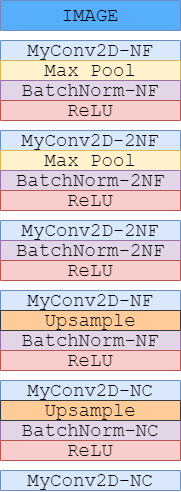

In the diagram, we denote the number of filters as **NF**. Further layers double the number of filters, denoted as **2NF**. In the final layers, the number of filters will be equivalent to the number of colour classes, denoted as **NC**. Consequently, the constructed neural network defines the number of input/output layers with respect to the variables `num_filters` and `num_colours`, as opposed to a constant value.


We use our own convolution module, `MyConv2d`, instead of PyTorch's `nn.Conv2D` to better understand its internals.  
Each MyConv2d layer is parameterized as follows:
- The number of channels in the image is defined in `num_in_channels`. This is used as the number of input filters for the first convolution.
- The number of output filters for each `MyConv2d` layer is specified after the hyphen. 
- The kernel size used in `MyConv2d` is specified via the `kernel` parameter.


For the remaining operations, we use default PyTorch implementations.  
The specific modules used are listed below. If parameters are not otherwise specified, use the default PyTorch parameters.

- [nn.MaxPool2d](https://pytorch.org/docs/stable/nn.html#maxpool2d): We use `kernel_size=2` for all layers.

- [nn.BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d): The number of features is specified after the hyphen in the diagram as a multiple of **NF** or **NC**.

- [nn.Upsample](https://pytorch.org/docs/stable/nn.html#upsample): We use `scaling_factor=2` for all layers.

- [nn.ReLU](https://pytorch.org/docs/stable/nn.html#relu)


We group each block of operations (those adjacent without whitespace in the diagram) into [nn.Sequential](https://pytorch.org/docs/stable/nn.html#sequential) containers for easier `forward implementation.


In [ ]:

class MyConv2d(nn.Module):
    """
    Our simplified implemented of nn.Conv2d module for 2D convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=None):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
        self.weight = nn.parameter.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.parameter.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels * self.kernel_size * self.kernel_size
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, padding=self.padding)


class CNN(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(CNN, self).__init__()
        padding = kernel // 2

        self.layer1 = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.MaxPool2d(kernel_size = 2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
            )
        
        self.layer2 = nn.Sequential(
            MyConv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.MaxPool2d(kernel_size = 2),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
            )

        self.layer3 = nn.Sequential(
            MyConv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
            )

        self.layer4 = nn.Sequential(
            MyConv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.Upsample(scale_factor =2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
            )
        
        self.layer5 = nn.Sequential(
            MyConv2d(num_filters, num_colours, kernel_size=kernel, padding=padding),
            nn.Upsample(scale_factor =2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU()
            )
        
        self.layer6 = MyConv2d(num_colours, num_colours, kernel_size=kernel)

    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        
        return x


## 1.3. Running the Training Loop & Results
We now run the main training loop of  the CNN. This trains the CNN model for a few epochs using the cross-entropy objective. It generates some images showing the trained result at the end.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Epoch [1/25], Loss: 3.4187, Time (s): 2
Epoch [1/25], Val Loss: 3.0557, Val Acc: 8.5%, Time(s): 2.48
Epoch [2/25], Loss: 2.7358, Time (s): 4
Epoch [2/25], Val Loss: 2.5827, Val Acc: 16.1%, Time(s): 4.50
Epoch [3/25], Loss: 2.4667, Time (s): 6
Epoch [3/25], Val Loss: 2.4051, Val Acc: 19.0%, Time(s): 6.57
Epoch [4/25], Loss: 2.3338, Time (s): 8
Epoch [4/25], Val Loss: 2.3345, Val Acc: 21.5%, Time(s): 8.67
Epoch [5/25], Loss: 2.2569, Time (s): 10
Epoch [5/25], Val Loss: 2.2211, Val Acc: 24.4%, Time(s): 10.80
Epoch [6/25], Loss: 2.2205, Time (s): 12
Epoch [6/25], Val Loss: 2.1768, Val Acc: 23.7%, Time(s): 12.97
Epoch [7/25], Loss: 2.1844, Time (s): 14
Epoch [7/25], Val Loss: 2.1541, Val Acc: 24.1%, Time(s): 15.17
Epoch [8/25], Loss: 2.1550, Time (s): 17
Epoch [8/25], Val Loss: 2.1659, Val Acc: 23.4%, Time(s): 17.39
Epoch [9/25], Loss: 2.1024, Time (s): 19
Epoch [9/25], Val Loss: 2.1539, Val Acc: 22.4%, Time(s): 19.63
Epoch [10/25], Loss: 2.0926, Time (s): 21
Epoch [10/25], Val Loss: 2.0580

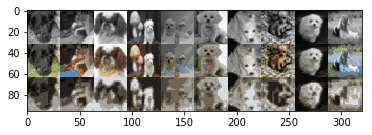

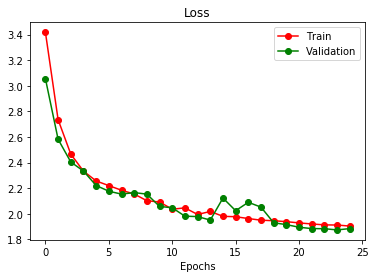

In [ ]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.3, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

The above two figures show the results of our training. Clearly, our model didn't learn too much. This is evident from the quality of the outputs which have very limited colourization compared to the ground truth (i.e. actual image colours in the second row). This in conjunciton with our training and validation loss curves indicate that our model is underfitting the data since both loss curves are very similar. Clearly, our model can use some work. In the next section, we explore a method for improving our CNN's performance.

# Part 2: Skip Connections


A skip connection in a neural network is a connection which skips one or more layer and connects
to a later layer. We will introduce skip connections to our previous model.

## 2.1. Implementing a UNet Model
In this section, we add a skip connection from the first layer to the last, second layer to the second last, etc. That is, the final convolution should have both the output of the previous layer and the initial greyscale input as input. This type of skip-connection is introduced by [Ronneberger et al.[2015]](https://arxiv.org/abs/1505.04597), and is called a ”UNet”. 

Just like the `CNN` class that we implemented in the previous part, we implement the `__init__` and `forward` methods methods of the `UNet` class below.



In [ ]:
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(UNet, self).__init__()
        padding = kernel // 2

        self.layer1 = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.MaxPool2d(kernel_size = 2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
            )
        
        self.layer2 = nn.Sequential(
            MyConv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.MaxPool2d(kernel_size = 2),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
            )

        self.layer3 = nn.Sequential(
            MyConv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
            )

        self.layer4 = nn.Sequential(
            MyConv2d(2*num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.Upsample(scale_factor = 2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
            )
        
        self.layer5 = nn.Sequential(
            MyConv2d(num_filters + num_filters, num_colours, kernel_size=kernel, padding=padding),
            nn.Upsample(scale_factor = 2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU()
            )
        
        self.layer6 = MyConv2d(num_colours + num_in_channels, num_colours, kernel_size=kernel)

    def forward(self, x):
        
        self.l1 = self.layer1(x)
        self.l2 = self.layer2(self.l1)
        self.l3 = self.layer3(self.l2)
        self.l4 = self.layer4(torch.cat((self.l3,self.l2),1))
        self.l5 = self.layer5(torch.cat((self.l4,self.l1),1))
        self.l6 = self.layer6(torch.cat((self.l5,x),1))
        
        return self.l6


## 2.2. Main Training Loop for UNet

We now train our UNet model and observe the results tp compare with our previous model.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.3073, Time (s): 2
Epoch [1/25], Val Loss: 1.9752, Val Acc: 31.9%, Time(s): 2.36
Epoch [2/25], Loss: 1.7964, Time (s): 4
Epoch [2/25], Val Loss: 1.7160, Val Acc: 38.5%, Time(s): 4.46
Epoch [3/25], Loss: 1.6699, Time (s): 6
Epoch [3/25], Val Loss: 1.6256, Val Acc: 40.6%, Time(s): 6.57
Epoch [4/25], Loss: 1.6083, Time (s): 8
Epoch [4/25], Val Loss: 1.5870, Val Acc: 41.4%, Time(s): 8.72
Epoch [5/25], Loss: 1.5696, Time (s): 10
Epoch [5/25], Val Loss: 1.5745, Val Acc: 40.9%, Time(s): 10.87
Epoch [6/25], Loss: 1.5403, Time (s): 12
Epoch [6/25], Val Loss: 1.5255, Val Acc: 42.9%, Time(s): 13.04
Epoch [7/25], Loss: 1.5139, Time (s): 14
Epoch [7/25], Val Loss: 1.4915, Val Acc: 44.4%, Time(s): 15.22
Epoch [8/25], Loss: 1.4894, Time (s): 17
Epoch [8/25], Val Loss: 1.4581, Val Acc: 45.6%, Time(s): 17.43
Epoch [9/25], Loss: 1.4687, Time (s): 19
Epoch [9/25], Val Loss: 1.4433, 

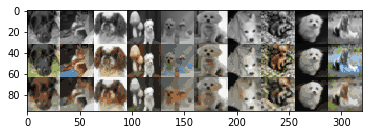

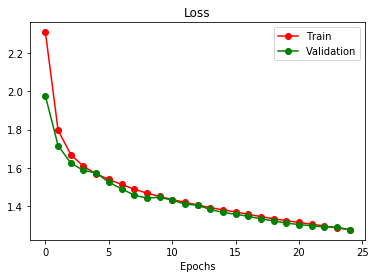

In [ ]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn = train(args)

## 2.3. Results

As can be observed from the above images, the skip connections dramatically improved the performance of our model. The validation accuracy improved by well over 20% and the validation loss also significantly decreased.

Qualitatively, it can be observed that the results of UNet are more colourful and closer to the ground truth image colours. The UNet outputs also appear to be sharper (have higher resolution).

Skip connections may improve the performance of the CNN models through: 
1. *Preserving key image features/details*: Since the pooling and upsampling layers eliminate granular image details, the addition of the input image to the final layer would aid the CNN in preserving the input images details during image reconstruction. 

2. *Mitigating impact of the vanishing gradients problem*: As the amount of layers increase, the influence of features that are learned earlier in the CNN on the final output diminishes. Therefore by having skip connections, the CNN remembers earlier features which may have been forgotten throughout the CNN model. 

# Part 3: Finetuning a Semantic Segmentation Model

In the previous two sections, we worked on training models for image colourization. We now switch gears and perform semantic segmentation by fine-tuning a pre-trained model. 
        
*Semantic segmentation* can be considered as a pixel-wise classification problem where we need to predict the class label for each pixel. Fine-tuning is often used when you only have limited labeled data.
        
Here, we take a pre-trained model on the [Microsoft COCO dataset](https://arxiv.org/abs/1405.0312) and fine-tune it to perform segmentation with the classes it was never trained on. To be more specific, we use the [**deeplabv3**](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/) pre-trained model and fine-tune it on the Oxford17 flower dataset.
        
We simplify the task to be a binary semantic segmentation task (background and flower). In the following code, we first observe some examples from the Oxford17 dataset and load the finetuned model by truncating the last layer of the network and replacing it with a randomly initialized convolutional layer. Note that we only update the weights of the newly introduced layer.


## 3.1. Helper code
The below helper functions are for setting up the dataset and visualization.

In [ ]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

### 3.1.1. Data Manipulation

In [ ]:
# Dataset helper function
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im/255.0 - imagenet_stats[0])/imagenet_stats[1]

def denormalize(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return img*imagenet_stats[1] + imagenet_stats[0]

# Mainly imported from https://colab.research.google.com/drive/1KzGRSNQpP4BonRKj3ZwGMTGdi-e2y8z-?authuser=1#scrollTo=U_g_Rq1cA1Xi
class CUB(Dataset):
    def __init__(self, files_path, split, train=True):
      
        self.files_path = files_path
        self.split = split
        if train:
            filenames = list(self.split['trn1'][0]) + list(self.split['trn2'][0]) + list(self.split['trn3'][0])
        else:
            # We only use `val1` for validation
            filenames = self.split['val1'][0]
        
        valid_filenames = []
        for i in filenames:
            img_name = 'image_%04d.jpg' % int(i)
            if os.path.exists(os.path.join(files_path, 'jpg', img_name)) and \
                os.path.exists(os.path.join(files_path, 'trimaps', img_name.replace('jpg', 'png'))):
                valid_filenames.append(img_name)

        self.valid_filenames = valid_filenames
        self.num_files = len(valid_filenames)
       
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        
        filename = self.valid_filenames[index]

        # Load the image
        path = os.path.join(self.files_path, 'jpg', filename)
        x = read_image(path)  # H*W*c
        x = cv2.resize(x, (224,224))
        x = normalize(x)
        x = np.rollaxis(x, 2) # To meet torch's input specification(c*H*W) 

        # Load the segmentation mask
        path = os.path.join(self.files_path, 'trimaps', filename.replace("jpg", "png"))
        y = read_image(path)
        y = cv2.resize(y, (224,224))  # H*W*c
        
        return x, y

def initialize_loader(train_batch_size=64, val_batch_size=64):
    split = loadmat("datasplits.mat")
    train_dataset = CUB('./', split, train= True)
    valid_dataset = CUB('./', split, train= False)
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size, num_workers=4)
    return train_loader, valid_loader

### 3.1.2. Visualization

In [ ]:
def visualize_dataset(dataloader):
    """Imshow for Tensor."""
    x, y = next(iter(dataloader))
    
    fig = plt.figure(figsize=(10, 5))
    for i in range(4):
      inp = x[i]
      inp = inp.numpy().transpose(1,2,0)
      inp = denormalize(inp)
      mask = y[i] / 255.
      
      ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
      plt.imshow(np.concatenate([inp, mask], axis=1))

def plot_prediction(args, model, is_train, index_list=[0], plotpath=None, title=None):

    train_loader, valid_loader = initialize_loader()
    loader = train_loader if is_train else valid_loader

    images, masks = next(iter(loader))
    images = images.float()
    if args.gpu:
        images = images.cuda()

    with torch.no_grad():
        outputs = model(images)['out']
    output_predictions = outputs.argmax(1)

    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    colors = [i for color in colors for i in color]

    for index in index_list:
        
        r = Image.fromarray(output_predictions[index].byte().cpu().numpy())
        r.putpalette(colors)

        fig = plt.figure(figsize=(10, 5))
        if title: plt.title(title)

        ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
        plt.imshow(denormalize(images[index].cpu().numpy().transpose(1,2,0)))

        ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
        plt.imshow(r)

        ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
        plt.imshow(masks[index])

        if plotpath:
            plt.savefig(plotpath)
            plt.close()

## 3.2. Downloading Dataset and Initializing DataLoader
Download the [Oxford17 Flower](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/) by running the code below. It will takes around 1 minutes for the first time.



In [ ]:
import os
if not os.path.exists("17flowers.tgz"):
    print("Downloading flower dataset")
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
    !tar xvzf 17flowers.tgz
if not os.path.exists("trimaps.tgz"):
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/17/trimaps.tgz
    !tar xvzf trimaps.tgz
if not os.path.exists("datasplits.mat"):
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/17/datasplits.mat

We run the code below to initialize `DataLoader` and visualize few examples 

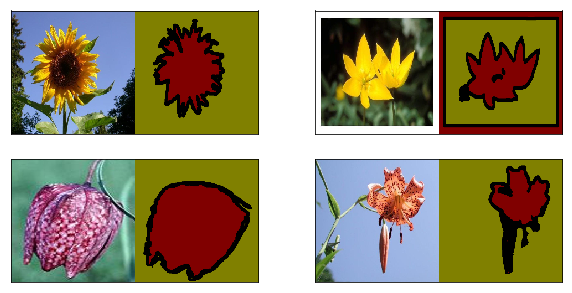

In [ ]:
train_loader, valid_loader = initialize_loader()
visualize_dataset(train_loader)

## 3.3. Loading Pre-Trained Model
PyTorch [Hub](https://pytorch.org/docs/stable/hub.html) supports publishing pre-trained models (model definitions and pre-trained weights) to a Github repository by adding a simple hubconf.py file. The code below downloads [deeplabv3](https://arxiv.org/pdf/1706.05587.pdf). 

<br>

We load and print the model below (we commented the print command because it's a very large model!).

In [ ]:
# For further details, please refer to: https://arxiv.org/pdf/1706.05587.pds
model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
#print(model)

## 3.4. Training
The below functions are implemented to help with training.

In [ ]:
def compute_loss(pred, gt):
    loss = F.cross_entropy(pred, gt)
    return loss

# from https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
def iou_pytorch(outputs, labels):
    
    SMOOTH = 1e-6
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = torch.argmax(outputs, 1)
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch

def convert_to_binary(masks, thres=0.5):
    binary_masks = ((masks[:, 0, :, :] ==  128) & (masks[:, 1, :, :] == 0) & (masks[:, 2, :, :] == 0)) + 0.
    return binary_masks.long()

def run_validation_step(args, epoch, model, loader, plotpath=None):

    model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).

    losses = []
    ious = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            permute_masks = masks.permute(0, 3, 1, 2)  # to match the input size: B, C, H, W
            binary_masks = convert_to_binary(permute_masks)
            if args.gpu:
                images = images.cuda()
                binary_masks = binary_masks.cuda()
            output = model(images.float())
            pred_seg_masks = output["out"]

            output_predictions = pred_seg_masks[0].argmax(0)
            loss = compute_loss(pred_seg_masks, binary_masks)
            iou = iou_pytorch(pred_seg_masks, binary_masks)
            losses.append(loss.data.item())
            ious.append(iou.data.item())

        val_loss = np.mean(losses)
        val_iou = np.mean(ious)
    
    if plotpath:
        plot_prediction(args, model, False, index_list=[0], plotpath=plotpath, title='Val_%d' % epoch)
    
    return val_loss, val_iou


For this task, we want to fine-tune only the last layer in our downloaded deeplabv3 model. We do this by keeping track of weights we want to update in `learned_parameters`. 
            
We use the PyTorch utility [`Model.named_parameters()`](https://pytorch.org/docs/stable/nn.html), which returns an iterator over all the weight matrices of the model.  The last layer weights have names prefix `classifier.4`. We will select the corresponding weights then passing them to `learned_parameters`.  
            

In [ ]:
def train(args, model):
    
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)
    # Numpy random seed
    np.random.seed(args.seed)
    
    # Save directory
    # Create the outputs folder if not created already
    save_dir = "outputs/" + args.experiment_name
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    learned_parameters = []

    # We only learn the last layer and freeze all the other weights 
    for name, param in model.named_parameters():
      if name[:12] == "classifier.4":
        learned_parameters.append(param)

    # Adam only updates learned_parameters
    optimizer = torch.optim.Adam(learned_parameters, lr=args.learn_rate)

    train_loader, valid_loader = initialize_loader(args.train_batch_size, args.val_batch_size)
    print("Train set: {}, Test set: {}".format(
            train_loader.dataset.num_files, valid_loader.dataset.num_files))

    print("Beginning training ...")
    if args.gpu: 
        model.cuda()

    start = time.time()
    trn_losses = []
    val_losses = []
    val_ious = []
    best_iou = None

    for epoch in range(args.epochs):
        

        # Train the Model
        model.train() # Change model to 'train' mode
        start_tr = time.time()
        
        losses = []
        for i, (images, masks) in enumerate(train_loader):

            

            permute_masks = masks.permute(0, 3, 1, 2)       # to match the input size: B, C, H, W
            binary_masks = convert_to_binary(permute_masks) # B, H, W
            if args.gpu:
                images = images.cuda()
                binary_masks = binary_masks.cuda()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            output = model(images.float())
            pred_seg_masks = output["out"]

            _, pred_labels = torch.max(pred_seg_masks, 1, keepdim=True)
            loss = compute_loss(pred_seg_masks, binary_masks)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            plot_prediction(args, model, True, index_list=[0], plotpath=save_dir+'/train_%d.png' % epoch, title='Train_%d' % epoch)

        # plot training images
        trn_loss = np.mean(losses)
        trn_losses.append(trn_loss)
        time_elapsed = time.time() - start_tr
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
                epoch+1, args.epochs, trn_loss, time_elapsed))

        # Evaluate the model

        start_val = time.time()
        val_loss, val_iou = run_validation_step(args, 
                                                epoch, 
                                                model,
                                                valid_loader, 
                                                save_dir+'/val_%d.png' % epoch)

        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), os.path.join(save_dir, args.checkpoint_name + '-best.ckpt'))

        time_elapsed = time.time() - start_val
        print('Epoch [%d/%d], Loss: %.4f, mIOU: %.4f, Validation time (s): %d' % (
                epoch+1, args.epochs, val_loss, val_iou, time_elapsed))
        
        val_losses.append(val_loss)
        val_ious.append(val_iou)


    # Plot training curve
    plt.figure()
    plt.plot(trn_losses, "ro-", label="Train")
    plt.plot(val_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/training_curve.png")

    # Plot validation iou curve
    plt.figure()
    plt.plot(val_ious, "ro-", label="mIOU")
    plt.legend()
    plt.title("mIOU")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/val_iou_curve.png")

    print('Saving model...')
    torch.save(model.state_dict(), os.path.join(save_dir, args.checkpoint_name + '-{}-last.ckpt'.format(args.epochs)))

    print('Best model achieves mIOU: %.4f' % best_iou)


For fine-tuning, we also
* use `Model.requires_grad_()` to prevent back-prop through all the layers that should be frozen
* replace the last layer with a new `nn.Conv2d` with appropriate input output channels and kernel sizes. Since we are performing binary segmentation for this assignment, this new layer has 2 output channels.


Train set: 1280, Test set: 212
Beginning training ...
Epoch [1/10], Loss: 5.7469, Time (s): 94
Epoch [1/10], Loss: 2.6653, mIOU: 0.1108, Validation time (s): 23
Epoch [2/10], Loss: 2.4269, Time (s): 93
Epoch [2/10], Loss: 1.0323, mIOU: 0.2042, Validation time (s): 22
Epoch [3/10], Loss: 1.4323, Time (s): 95
Epoch [3/10], Loss: 0.6614, mIOU: 0.2552, Validation time (s): 22
Epoch [4/10], Loss: 1.0039, Time (s): 93
Epoch [4/10], Loss: 0.5953, mIOU: 0.2802, Validation time (s): 22
Epoch [5/10], Loss: 0.6683, Time (s): 95
Epoch [5/10], Loss: 0.3883, mIOU: 0.3000, Validation time (s): 22
Epoch [6/10], Loss: 0.5907, Time (s): 94
Epoch [6/10], Loss: 0.5197, mIOU: 0.2778, Validation time (s): 22
Epoch [7/10], Loss: 0.4769, Time (s): 94
Epoch [7/10], Loss: 0.3948, mIOU: 0.3179, Validation time (s): 22
Epoch [8/10], Loss: 0.3725, Time (s): 96
Epoch [8/10], Loss: 0.2939, mIOU: 0.3217, Validation time (s): 23
Epoch [9/10], Loss: 0.3075, Time (s): 95
Epoch [9/10], Loss: 0.2875, mIOU: 0.2986, Validat

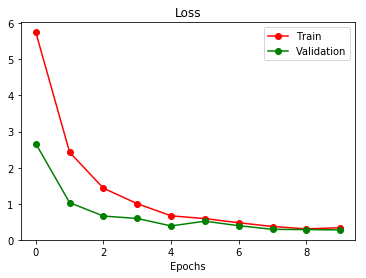

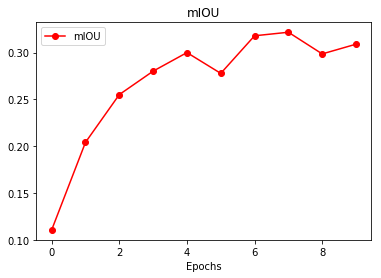

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict()

args_dict = {
              'gpu':True, 
              'checkpoint_name':"finetune-segmentation", 
              'learn_rate':0.05, 
              'train_batch_size':128, 
              'val_batch_size': 256, 
              'epochs':10, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'finetune-segmentation',
}
args.update(args_dict)

model.requires_grad_(requires_grad=False)

model.classifier[4] = torch.nn.Conv2d(256, 2, 3)

# Clear the cache in GPU
torch.cuda.empty_cache()
train(args, model)

## 3.4. Training Results
We now visualize the predictions by running the helper code provided above on both training and testing data. The first column contains the original images, the second column is our model's outputted segmentation between flower and background, and the third column is what the actual segmentation is (i.e. label/ground-truth).

First, we look at our model's performance on samples from the training set:

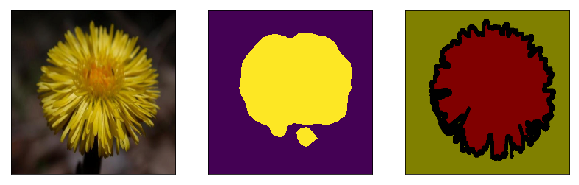

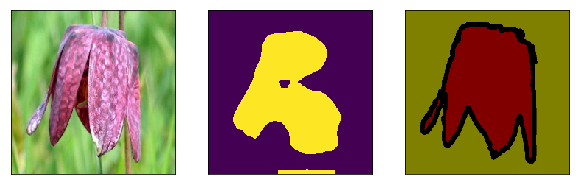

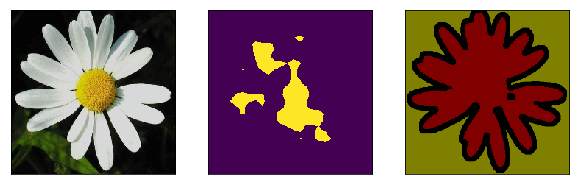

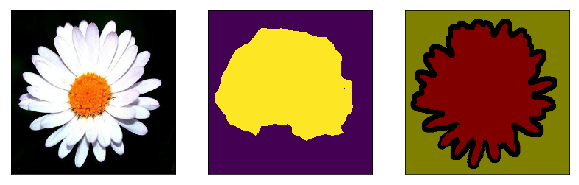

In [ ]:
plot_prediction(args, model, is_train=True, index_list=[0, 1, 2, 3])

We now look at our model's segmentation of some images from our test set:

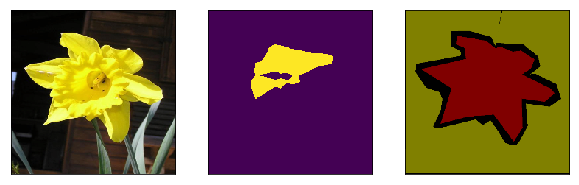

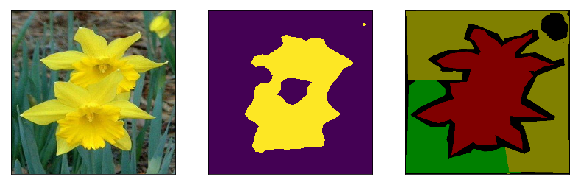

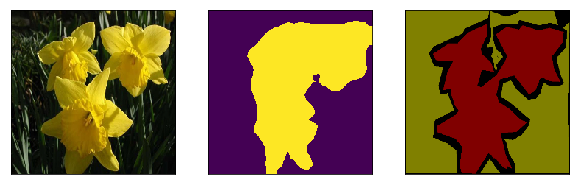

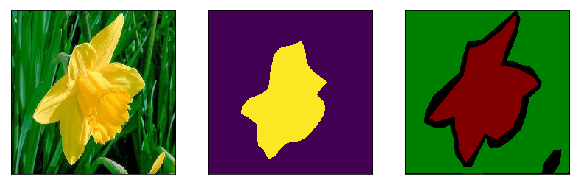

In [ ]:
plot_prediction(args, model, is_train=False, index_list=[0, 1, 2, 3])

Quite remarkably, our model can clearly distinguish between the *body* of a flower and the background consistently. Where our model seems to struggle is in the finer details such as petal boundaries, especially when there are many smaller petals.

# References
* Jimmy Ba.  Convolutional Neural Networks. *University of Toronto, CSC413*, 2020.

* Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks for biomedical image segmentation. In *International Conference on Medical image computing and computerassisted intervention*, pages 234–241. Springer, 2015.

* Tsung-Yi Lin, Michael Maire, Serge Belongie, James Hays, Pietro Perona, Deva Ramanan, Piotr
Doll´ar, and C Lawrence Zitnick. Microsoft coco: Common objects in context. In *European
conference on computer vision*, pages 740–755. Springer, 2014.

* Liang-Chieh Chen, George Papandreou, Florian Schroff, and Hartwig Adam. Rethinking atrous
convolution for semantic image segmentation. *arXiv preprint arXiv:1706.05587*, 2017.

* Maria-Elena Nilsback and Andrew Zisserman. Automated flower classification over a large number
of classes. In *2008 Sixth Indian Conference on Computer Vision, Graphics & Image Processing*,
pages 722–729. IEEE, 2008.




